In [1]:
import os
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import *
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
import pickle as pkl
import joblib
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

Hi there, Pranshu rastogi this side.

For this round i was assigned to work on a small project. 
where I have to create a  model where we have to match a "single receipt to the correct transaction 
given a number of possible transactions however, given real world considerations, 
we want to sort the possible transactions for a given receipt in order of
likelihood of being the correct transaction." or to be very easily said we have predict whether if 
"matched_transaction_id == feature_transaction_id"  with specific "receipt_id" & "merchant_id/company_id"

so my approach is to solve this with a binary classification problem and then sorting it with respect to receipt_id & merchant_id
receipt_id member_id matched_transaction_id feature_transaction_id

1234      | abcd123 |                  xyz | qwe

1234      | abcd123 |                  xyz | xyz

1234      | abcd123 |                  xyz | cvb

"the correct transaction which maps to this receipt is transaction
xyz, which passed the filtering and is in the data set (row 2) and also two other transactions
passed the filtering for this receipt_id (transactions qwe and cvb) but these are incorrect
matchings."

But to start with lets first look at the data provided to us

### Glance of Unformated Csv
when we see the data the columns are somewhat not in order ;). so we have to first formulate the data into an readable form 

In [2]:
df = pd.read_csv('../input/tide-match-data/data_interview_test.csv')
df

receipt_id:company_id:matched_transaction_id:feature_transaction_id:DateMappingMatch:AmountMappingMatch:DescriptionMatch:DifferentPredictedTime:TimeMappingMatch:PredictedNameMatch:ShortNameMatch:DifferentPredictedDate:PredictedAmountMatch:PredictedTimeCloseMatch
10 000:10000:10 468:10  000:0.0000:0.0000:0.0000:1.0000:0.0000:0.0000:...                                                                                                                                                                                                                    
                468:10  001:0.0000:0.0000:0.0000:1.0000:0.0000:0.0000:...                                                                                                                                                                                                                    
                468:10  003:0.0000:0.0000:0.0000:1.0000:0.0000:0.0000:...                                                                                                                                                                                                                    
                468:10  004:0.0000:0.0000:0.0000:1.0000:0.0000:0.0000:...                                                                                                                                                                                                                    
                468:10  005:0.0000:0.0000:0.0000:1.0000:0.0000:0.0000:...                                                                                                                                                                                                                    
...                                                                   ...                                                                                                                                                                                                                    
50 226:50000:50 368:50  074:0.6500:0.0000:0.0000:1.0000:0.0000:0.0000:...                                                                                                                                                                                                                    
                368:50  075:0.6500:0.0000:0.0000:1.0000:0.0000:0.0000:...                                                                                                                                                                                                                    
                368:50  366:0.0000:0.0000:0.0000:1.0000:0.0000:0.0000:...                                                                                                                                                                                                                    
                368:50  367:0.0000:0.0000:0.0000:1.0000:0.0000:0.0000:...                                                                                                                                                                                                                    
                368:50  368:0.9500:0.0000:0.0000:1.0000:0.0000:0.0000:...                                                                                                                                                                                                                    

[12034 rows x 1 columns]

In [3]:
l = []
for i in df.values:
    l.append(i[-1].split(":"))

In [4]:
df = df.reset_index()

In [5]:
df2 = pd.DataFrame(l)

In [6]:
df1 = df[['level_0','level_1','level_2']]
df1.columns = df.columns[-1].split(":")[:3]

In [7]:
df2.columns = df.columns[-1].split(":")[3:]

In [8]:
df3 = pd.concat([df1,df2], axis = 1)

Above cells helped us to have some sort of structure but we now have to look on company_id & matched_transaction_id

so clean these columns like company_id/matched_transaction_id we have to split it on ":" and take the first element
### Glance at Sanitized csv

In [9]:
df3

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch
0,10,000:10000:10,468:10,000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
1,10,000:10000:10,468:10,001,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
2,10,000:10000:10,468:10,003,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
3,10,000:10000:10,468:10,004,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
4,10,000:10000:10,468:10,005,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12029,50,226:50000:50,368:50,074,0.6500,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
12030,50,226:50000:50,368:50,075,0.6500,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
12031,50,226:50000:50,368:50,366,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000
12032,50,226:50000:50,368:50,367,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000


In [10]:
df3['company_id'] = df3['company_id'].apply(lambda x : x.split(":")[0])
df3['matched_transaction_id'] = df3['matched_transaction_id'].apply(lambda x : x.split(":")[0])

In [11]:
df3['receipt_id'].value_counts()

30    4926
20    2375
10    2351
50    1383
40     999
Name: receipt_id, dtype: int64

this is where we are creating the labels its simple as first we are segregating the data where  matched_id == feature_id column values are same and then labelling them as 1. same goes with other where matched_id != feature_id and making them as 0
so this is how we are creating the labels

Class 0: 858 (7%)

Class 1: 11176 (93%)

**so we have a dataset now where if a row in a dataframe belongs to class 1 if the values of columns matched_id == feature_id are equal.
hence our problem boils down to a simple binay classification task. where we have to tell whether a row in a data frame belongs to class 1 or not and if it is. then we can say that we have found a match for corresponding value of reciept_id and company_id/member_id** 

***Since model will provide probablities we can just sort the rows on them under every group of reciept_id and company_id/member_id in descending order and so the most probable match row would come at on TOP and rest will follow according to probablities***

In [12]:
df4 = df3[df3['matched_transaction_id']==df3['feature_transaction_id']]
df4['class'] = 1
df5 = df3[df3['matched_transaction_id']!=df3['feature_transaction_id']]
df5['class'] = 0

In [13]:
for i in df3.columns:
    df3[i] = df3[i].astype(float)
    df4[i] = df4[i].astype(float)
    df5[i] = df5[i].astype(float)

In [14]:
df4.describe()

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,class
count,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.0
mean,30.466200,138.585082,366.465035,366.465035,0.904633,0.035664,0.150583,0.832168,0.171329,0.161538,0.261072,0.015152,0.006643,0.284382,1.0
std,13.757931,93.927293,222.947465,222.947465,0.121571,0.138203,0.284128,0.373935,0.377016,0.311976,0.439475,0.122227,0.057689,0.451383,0.0
min,10.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,20.000000,61.250000,204.250000,204.250000,0.850000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,30.000000,129.000000,324.000000,324.000000,0.950000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,40.000000,198.000000,506.750000,506.750000,0.950000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.0
max,50.000000,396.000000,999.000000,999.000000,1.000000,0.900000,0.800000,1.000000,1.000000,0.800000,1.000000,1.000000,0.600000,1.000000,1.0


In [15]:
df5.describe()

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,class
count,11176.000000,11176.000000,11176.000000,11176.000000,11176.000000,11176.000000,11176.000000,11176.000000,11176.000000,11176.000000,11176.000000,11176.000000,11176.000000,11176.000000,11176.0
mean,27.000716,149.224857,408.087330,221.322387,0.165180,0.031353,0.011614,0.998300,0.001790,0.013672,0.020759,0.810218,0.000573,0.060576,0.0
std,11.845629,97.558622,227.476217,246.079759,0.345106,0.121333,0.084680,0.041199,0.042267,0.093794,0.142582,0.392146,0.013366,0.238562,0.0
min,10.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,20.000000,69.000000,256.000000,19.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0
50%,30.000000,140.000000,394.000000,116.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0
75%,30.000000,206.000000,556.000000,372.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0
max,50.000000,397.000000,999.000000,999.000000,1.000000,0.900000,0.800000,1.000000,1.000000,0.800000,1.000000,1.000000,0.500000,1.000000,0.0


Now to check the difference b/w the columns mean/std so i can see some good differences
1. DateMappingMatch of data with label 0 is very much different with label 1
2. AmountMappingMatch with label 0 is similar with label 1 cols also
3. DescriptionMatch with label 0 is a little bit different with other label 1 data
4. DifferentPredictedTime is also different in there means
5. TimeMappingMatch  and DifferentPredictedDate is also different

so these columns are way to go for modelling

In [16]:
df4_f = df4[['DateMappingMatch','AmountMappingMatch','DescriptionMatch','DifferentPredictedTime',
     'TimeMappingMatch','PredictedNameMatch','ShortNameMatch','DifferentPredictedDate','PredictedAmountMatch','PredictedTimeCloseMatch']]
df5_f = df5[['DateMappingMatch','AmountMappingMatch','DescriptionMatch','DifferentPredictedTime',
     'TimeMappingMatch','PredictedNameMatch','ShortNameMatch','DifferentPredictedDate','PredictedAmountMatch','PredictedTimeCloseMatch']]

Now look on some graphs to see differences

In [17]:
df6 = pd.concat([df4,df5]).reset_index(drop = True)

<AxesSubplot:ylabel='Density'>

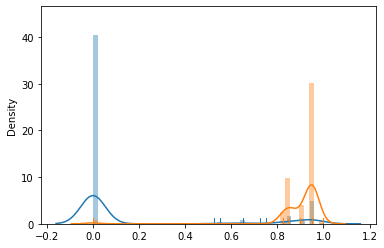

In [18]:
sns.distplot(df5_f[['DateMappingMatch']], rug=True)
sns.distplot(df4_f[['DateMappingMatch']], rug=True)

as seeing the distribution the difference b/w these densities
the orange one is of class 1 and blue is of class 0
would play as a great feature.

<AxesSubplot:xlabel='DateMappingMatch', ylabel='count'>

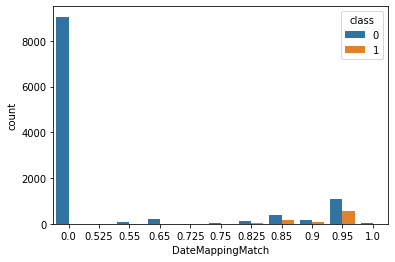

In [19]:
sns.countplot('DateMappingMatch',hue='class',data=df6)

<AxesSubplot:ylabel='Frequency'>

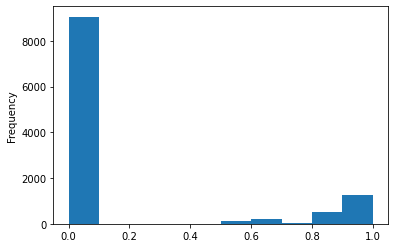

In [20]:
df6[df6['class']==0]['DateMappingMatch'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

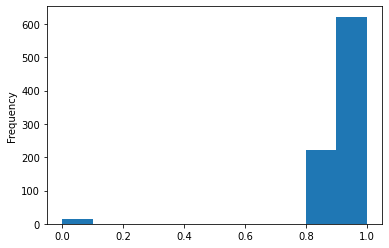

In [21]:
df6[df6['class']==1]['DateMappingMatch'].plot.hist()

as we see in this plot when the class is 1 the distribution is skewed towards the 1 and when its is 0 then the data is towards the left side but do have some density around 0.8-1.0

<AxesSubplot:ylabel='Density'>

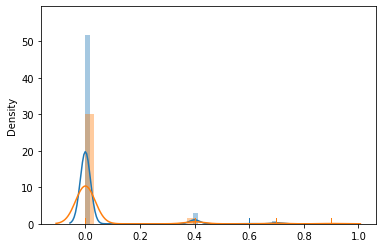

In [22]:
sns.distplot(df5_f[['AmountMappingMatch']], rug=True)
sns.distplot(df4_f[['AmountMappingMatch']], rug=True)

around all of the densities for both of the labels overlap very much so might not be a great indicator

<AxesSubplot:xlabel='AmountMappingMatch', ylabel='count'>

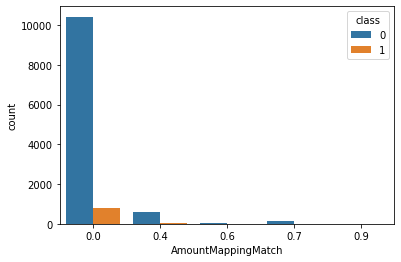

In [23]:
sns.countplot('AmountMappingMatch',hue='class',data=df6)

<AxesSubplot:ylabel='Frequency'>

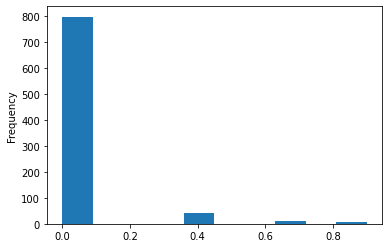

In [24]:
df6[df6['class']==1]['AmountMappingMatch'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

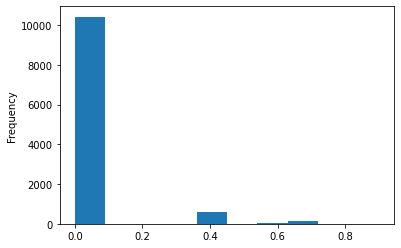

In [25]:
df6[df6['class']==0]['AmountMappingMatch'].plot.hist()

we can see a very little difference but still feature engineering should be done

<AxesSubplot:ylabel='Density'>

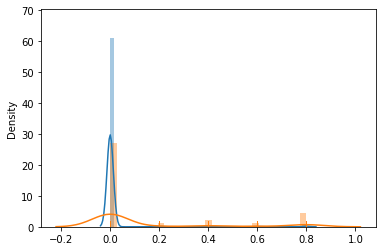

In [26]:
sns.distplot(df5_f[['DescriptionMatch']], rug=True)
sns.distplot(df4_f[['DescriptionMatch']], rug=True)

label 1 (orange) has fat-tails 

<AxesSubplot:xlabel='DescriptionMatch', ylabel='count'>

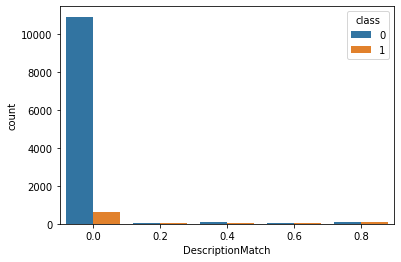

In [27]:
sns.countplot('DescriptionMatch',hue='class',data=df6)

<AxesSubplot:ylabel='Frequency'>

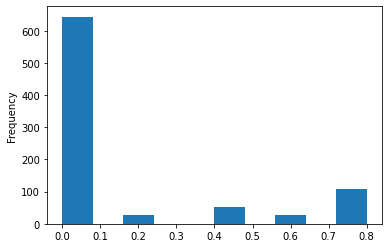

In [28]:
df6[df6['class']==1]['DescriptionMatch'].plot.hist()

here we can compare both of the graphs the distribution increases towards value of 1. as seen in class 0 the only distribution is towards 0

<AxesSubplot:ylabel='Frequency'>

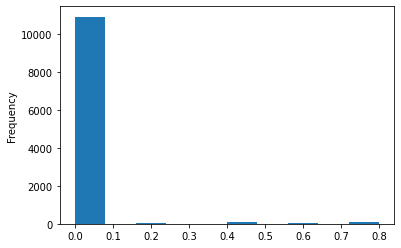

In [29]:
df6[df6['class']==0]['DescriptionMatch'].plot.hist()

<AxesSubplot:ylabel='Density'>

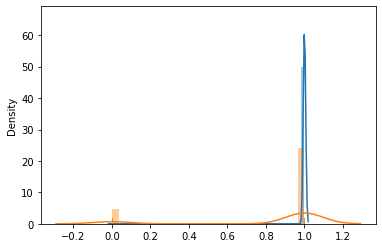

In [30]:
sns.distplot(df5_f[['DifferentPredictedTime']], rug=True)
sns.distplot(df4_f[['DifferentPredictedTime']], rug=True)

<AxesSubplot:xlabel='class', ylabel='count'>

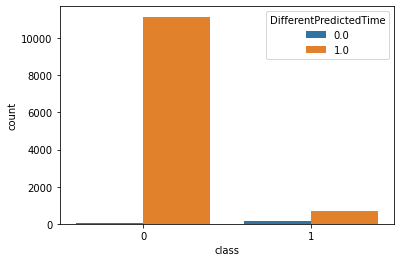

In [31]:
sns.countplot('class',hue='DifferentPredictedTime',data=df6)

<AxesSubplot:ylabel='Frequency'>

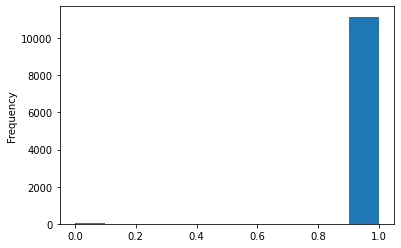

In [32]:
df6[df6['class']==0]['DifferentPredictedTime'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

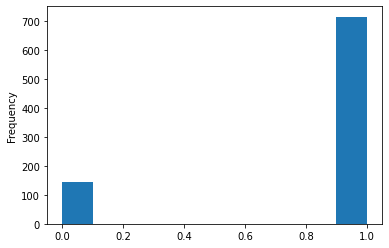

In [33]:
df6[df6['class']==1]['DifferentPredictedTime'].plot.hist()

for class 1 the values are mostly around 1 and around 150 of them are also 0 which is very different other class values which has only values of 1s

<AxesSubplot:ylabel='Density'>

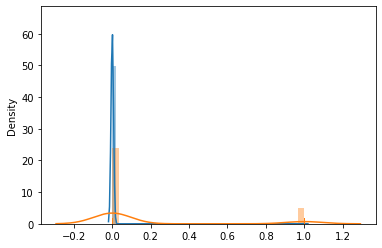

In [34]:
sns.distplot(df5_f[['TimeMappingMatch']], rug=True)
sns.distplot(df4_f[['TimeMappingMatch']], rug=True)

<AxesSubplot:xlabel='class', ylabel='count'>

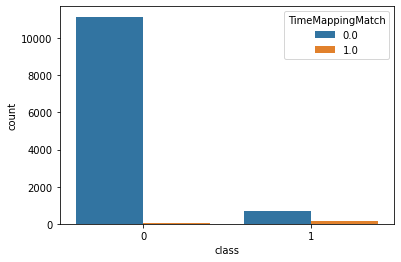

In [35]:
sns.countplot('class',hue='TimeMappingMatch',data=df6)

<AxesSubplot:xlabel='TimeMappingMatch', ylabel='count'>

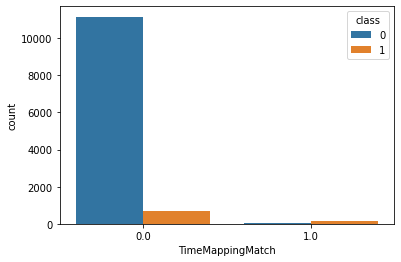

In [36]:
sns.countplot('TimeMappingMatch',hue='class',data=df6)

<AxesSubplot:ylabel='Frequency'>

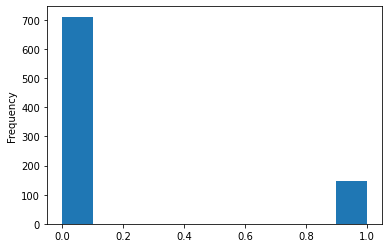

In [37]:
df6[df6['class']==1]['TimeMappingMatch'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

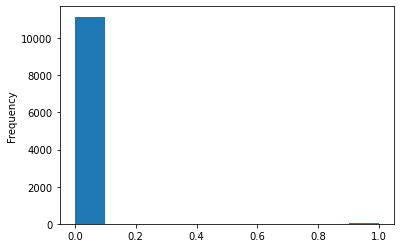

In [38]:
df6[df6['class']==0]['TimeMappingMatch'].plot.hist()

for TimeMappingMatch values of class 1 has some little more 1s in difference with class 0 could be used for FE with some combinations

<AxesSubplot:ylabel='Density'>

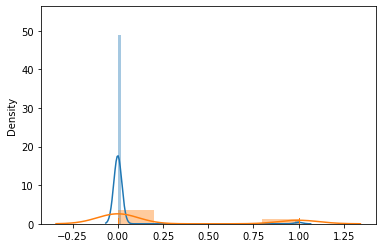

In [39]:
sns.distplot(df5_f[['ShortNameMatch']], rug=True)
sns.distplot(df4_f[['ShortNameMatch']], rug=True)

<AxesSubplot:ylabel='Frequency'>

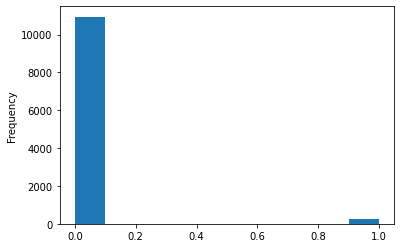

In [40]:
df6[df6['class']==0]['ShortNameMatch'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

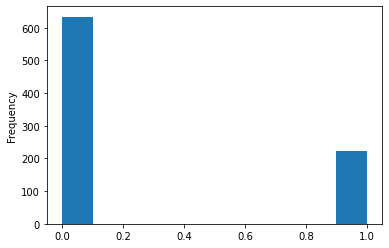

In [41]:
df6[df6['class']==1]['ShortNameMatch'].plot.hist()

ShortNameMatch is also has same nature with other categorical features as explained aboves

<AxesSubplot:ylabel='Density'>

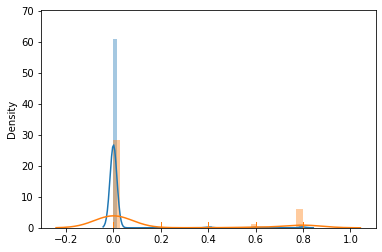

In [42]:
sns.distplot(df5_f[['PredictedNameMatch']], rug=True)
sns.distplot(df4_f[['PredictedNameMatch']], rug=True)

<AxesSubplot:ylabel='Frequency'>

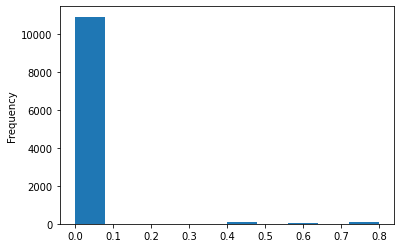

In [43]:
df6[df6['class']==0]['PredictedNameMatch'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

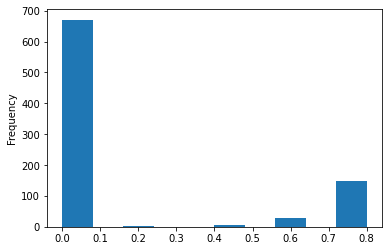

In [44]:
df6[df6['class']==1]['PredictedNameMatch'].plot.hist()

though there is some difference b/w the class label distributions but still there are many values with same value (0) so they might not be a very great feature 

<AxesSubplot:ylabel='Density'>

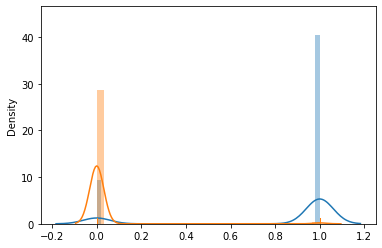

In [45]:
sns.distplot(df5_f[['DifferentPredictedDate']], rug=True)
sns.distplot(df4_f[['DifferentPredictedDate']], rug=True)

<AxesSubplot:xlabel='DifferentPredictedDate', ylabel='count'>

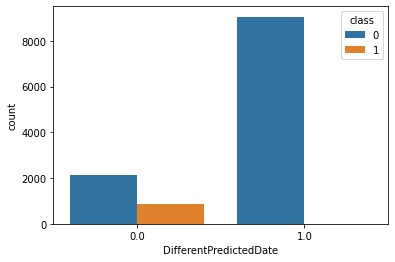

In [46]:
sns.countplot('DifferentPredictedDate',hue='class',data=df6)

<AxesSubplot:ylabel='Frequency'>

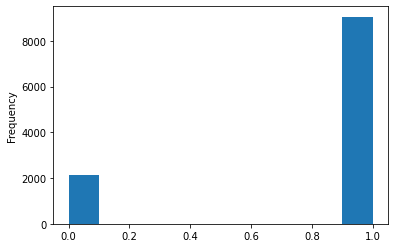

In [47]:
df6[df6['class']==0]['DifferentPredictedDate'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

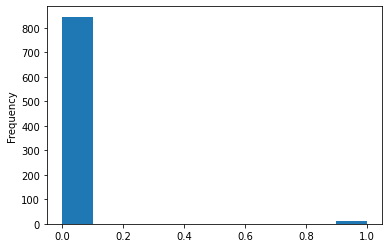

In [48]:
df6[df6['class']==1]['DifferentPredictedDate'].plot.hist()

DifferentPredictedDate - here we see a clear change in value so yeah a great indicator for modelling

<AxesSubplot:ylabel='Density'>

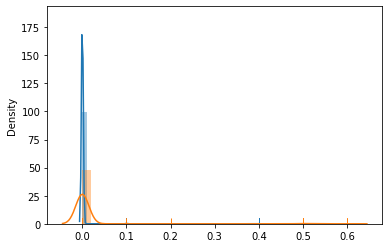

In [49]:
sns.distplot(df5_f[['PredictedAmountMatch']], rug=True)
sns.distplot(df4_f[['PredictedAmountMatch']], rug=True)

though we have long tails but still the distribution is same as that of other class 0. both of them quiet overlap

<AxesSubplot:ylabel='Frequency'>

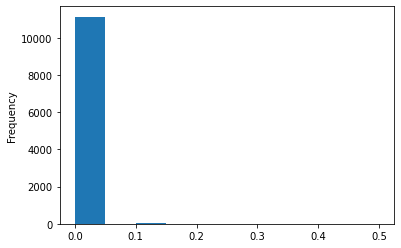

In [50]:
df6[df6['class']==0]['PredictedAmountMatch'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

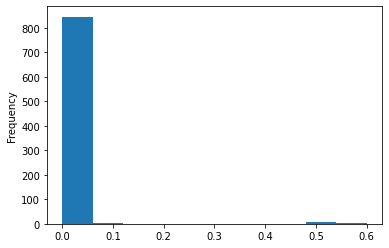

In [51]:
df6[df6['class']==1]['PredictedAmountMatch'].plot.hist()

<AxesSubplot:ylabel='Density'>

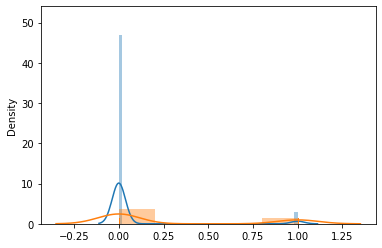

In [52]:
sns.distplot(df5_f[['PredictedTimeCloseMatch']], rug=True)
sns.distplot(df4_f[['PredictedTimeCloseMatch']], rug=True)

<AxesSubplot:ylabel='Frequency'>

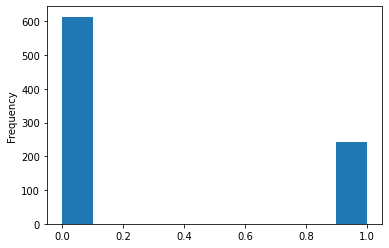

In [53]:
df6[df6['class']==1]['PredictedTimeCloseMatch'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

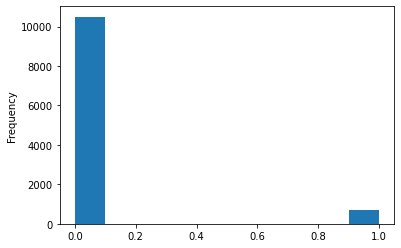

In [54]:
df6[df6['class']==0]['PredictedTimeCloseMatch'].plot.hist()

Now we have seen the feature analysis part where some labels are good for modelling but most of them has fat/long tails or do have some sort of segregation with distributions of categorical values as we have seen in above classwise graphs
to go with the columns to create features we are first looking on columns that we want to remove 

['receipt_id','company_id','matched_transaction_id','feature_transaction_id','DifferentPredictedDate', 'DifferentPredictedTime']

in these columns receipt_id, company_id, matched_transaction_id, feature_transaction_id are removed just for the sake of no leakage of label information as matched_transaction_id, feature_transaction_id are both involved in making the features
while the othe columns 'DifferentPredictedDate', 'DifferentPredictedTime' are removed becoz they are  highy correlated with another columns avialable in the dataset

In [55]:
df6 = pd.concat([df4,df5]).reset_index(drop = True)
feats = list(df6.columns)
feats.remove('class')
df6[feats] = df6[feats] + 1
df6 = df6.drop(columns = ['receipt_id','company_id','matched_transaction_id','feature_transaction_id','DifferentPredictedDate', 'DifferentPredictedTime'])
feats = ['DateMappingMatch','AmountMappingMatch','DescriptionMatch','TimeMappingMatch','PredictedNameMatch',
     'ShortNameMatch','PredictedAmountMatch','PredictedTimeCloseMatch']

numerical_cols_original = ['DateMappingMatch','PredictedNameMatch','DescriptionMatch']
categorical_cols_original = ['AmountMappingMatch','TimeMappingMatch','PredictedAmountMatch','ShortNameMatch','PredictedTimeCloseMatch']

Since we donot have meaning to these columns known to us to create some meaningful features. we are looking to create some interaction based features so we can create more diverse and non linear features on them

the FE techniques that we will talk about are creating some polynomial interaction features so that we can create columns are more different and correlated towards the class labels

with this we can also see the distributional representation of the data points and can check how much seperable are they

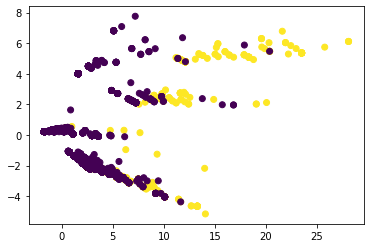

0.9577031743393718

In [56]:
poly_feats = PolynomialFeatures(degree = 3, interaction_only = True)
total_data = pd.DataFrame(poly_feats.fit_transform(df6[feats]))
total_data.columns = poly_feats.get_feature_names_out(feats)
df7 = total_data.drop(columns = ['1'])

pca = PCA(n_components=5)
feature_cols = df7.columns
X_pca = pca.fit_transform(df7[feature_cols])

X_pca = pd.DataFrame(X_pca, columns=['pca_'+ str(i) for i in range(5)], index=df6.index)

new = pd.concat([X_pca], axis=1)
new['class'] = df6['class']
new.head()
plt.scatter(new['pca_0'],new['pca_1'], c = df6['class'] )
plt.show()
clf = LogisticRegression(random_state=0).fit(X_pca, df6['class'])
clf.score(X_pca, df6['class'])

you can see the plot of Data points where the yellow is class 1 and purple is class 0

here we can see that the logistic regression model produced a score of 95.7% accuracy though it is done just to give us an brief idea on what number we should look for also this is accuracy and 93% are 0s only so we have still way to got

Text(0.5, 1.0, 'class 1')

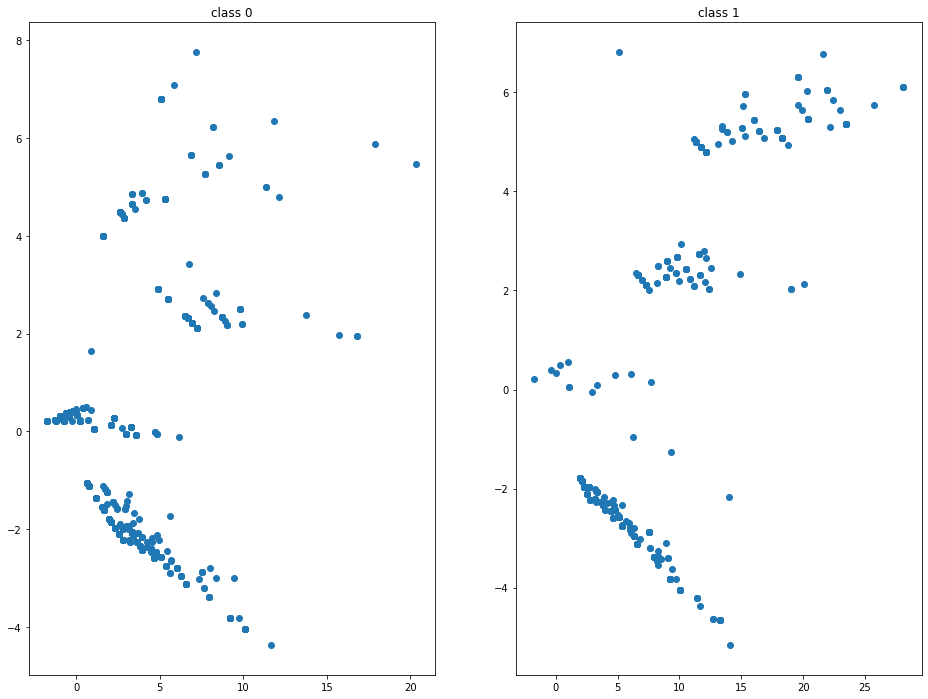

In [57]:
plt.figure(figsize=(16,12))
plt.subplot(1,2,1)
plt.scatter(new[new['class']==0]['pca_0'],new[new['class']==0]['pca_1'])
plt.title('class 0')
plt.subplot(1,2,2)
plt.scatter(new[new['class']==1]['pca_0'],new[new['class']==1]['pca_1'])
plt.title('class 1')

now this is something interesting to see. we can see some regions that both of the class distribution points overlap for both of the classes. also there might an issue of label noise as for some points they are perfectly overlaping and this is with some minor feature engineering also

In [58]:
feats = ['DateMappingMatch', 'AmountMappingMatch', 'DescriptionMatch','TimeMappingMatch', 'PredictedNameMatch', 'ShortNameMatch','PredictedAmountMatch', 'PredictedTimeCloseMatch']
for i in feats:
    feats2work = feats
    feats2work.remove(i)
    for j in feats2work:
        finals = df6.groupby(i)[j].agg(['mean', 'std', 'min', 'skew', 'count', 'nunique','median','cumsum'])
        finals.columns = [i + '_' + j + '_' + k for k in finals.columns]
        df6 = df6.join(finals, on = i)

Here i am creating features on the basis of groupby operation. we select a feature that will play as a pivot and others are loop around it  for aggregation like mean, std, min, skew, counts, nunique, median, cumsum. why just to capture those pattern like where a conjoint relation could be leveraged

In [59]:
columns_a = ['DateMappingMatch', 'DescriptionMatch', 'TimeMappingMatch', 'ShortNameMatch', 'PredictedAmountMatch']
columns_b = ['AmountMappingMatch', 'PredictedTimeCloseMatch', 'PredictedNameMatch']

for col_a in columns_a:
    for col_b in columns_b:
        for df in [df6]:
            df[f'{col_a}_div_mean_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].mean()
            df[f'{col_a}_div_std_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].std()
            df[f'{col_a}_div_median_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].median()
            df[f'{col_a}_div_var_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].count()
            df[f'{col_a}_div_max_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].max()
            df[f'{col_a}_div_min_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].min()
            
for col_a in columns_a:
    for col_b in columns_b:
        for df in [df6]:
            df[f'{col_a}_sub_mean_{col_b}'] = df[col_a]   - df.groupby([col_b])[col_a].mean()
            df[f'{col_a}_sub_std_{col_b}'] = df[col_a]    - df.groupby([col_b])[col_a].std()
            df[f'{col_a}_sub_median_{col_b}'] = df[col_a] - df.groupby([col_b])[col_a].median()
            df[f'{col_a}_sub_var_{col_b}'] = df[col_a]    - df.groupby([col_b])[col_a].var()
            df[f'{col_a}_sub_max_{col_b}'] = df[col_a]    - df.groupby([col_b])[col_a].max()
            df[f'{col_a}_sub_min_{col_b}'] = df[col_a]    - df.groupby([col_b])[col_a].min()
           

these features are an addons on the previous thinking that those features that capture a relation between the columns should have more interaction between them or so to say a way tp create more complex features.

In [60]:
feats = ['DateMappingMatch', 'AmountMappingMatch', 'DescriptionMatch','TimeMappingMatch', 'PredictedNameMatch', 'ShortNameMatch','PredictedAmountMatch', 'PredictedTimeCloseMatch']
for i in feats:
    feats2work = feats
    feats2work.remove(i)
    for j in feats2work:
        df6[i+'div'+j] = df6[i]/df6[j]
        df6[i+'mul'+j] = df6[i]*df6[j]
        df6[i+'add_div'+j] = (df6[i]+df6[j])/df6[i]
        df6[i+'sub_mul'+j] = (df6[i]-df6[j])*df6[i]

In [61]:
#corr_matrix = df7.corr().abs()
# Select upper triangle of correlation matrix
#upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find features with correlation greater than 0.95
#to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
# Drop features 
#df6.drop(to_drop, axis=1, inplace=True)

In [62]:
df7 = df7.drop(columns = ['DateMappingMatch', 'AmountMappingMatch', 
                          'DescriptionMatch','TimeMappingMatch', 'PredictedNameMatch', 
                          'ShortNameMatch','PredictedAmountMatch', 'PredictedTimeCloseMatch'])
df6 = pd.concat([df7, df6], axis = 1)

Now after the creation of features we can remove the columns with which they are created so that we can remove correlation between them if any and hence now we are ready to goo :)

In [63]:
df6 = df6.fillna(0)
df6.replace([np.inf, -np.inf], 0, inplace=True)

In [64]:
df6.to_csv('final_features.csv',index = False)

So to look forward with traning i have used very basic modelling strategy and done crude feature redeuction(PCA) on all feature.
since we have around 536 features to use i though the best and quick way is to use PCA over them and reduce the dimension. while keep as much info as possible, i have also trained a model on 536 features as well for interpretability and they give same results but took 3x more time in training and also curse of high dimension. I have taken 30 components for PCA

as per training strategy i have splitted the dataset into 80/20 class-wise. and then this 20% is held out and 80% is used for 10-fold strafiedkfold training and every fold model is tested on held-out dataset(20%) and after the 10 folds the performance is averaged and then final metrics and graphs are printed we have seen some good numbers in the metric side with a simple xgboost model. though Lgbm also works well but its not productionizable as it some time produces very weired results in my experiment. might be becoz of saving/loading or even arrangement of columns or something
https://muttoni.github.io/blog/machine-learning/2021/01/22/Fixing-Inconsistent-LightGBM-Predictions-In-Production.html

f1_score 92% (macro), 85% (class 1), 98% (class0), 98% accuracy

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2205
           1       0.99      0.74      0.85       202

    accuracy                           0.98      2407
   macro avg       0.98      0.87      0.92      2407
weighted avg       0.98      0.98      0.98      2407



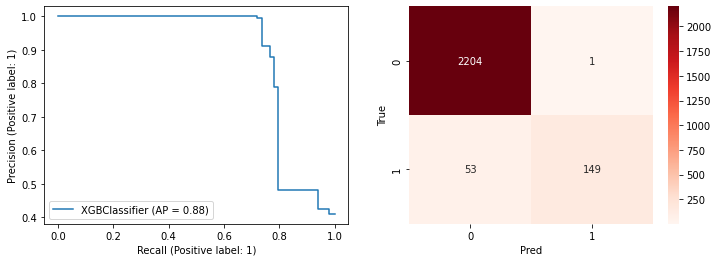

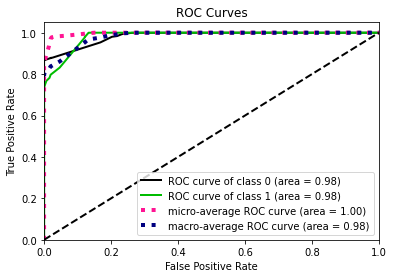

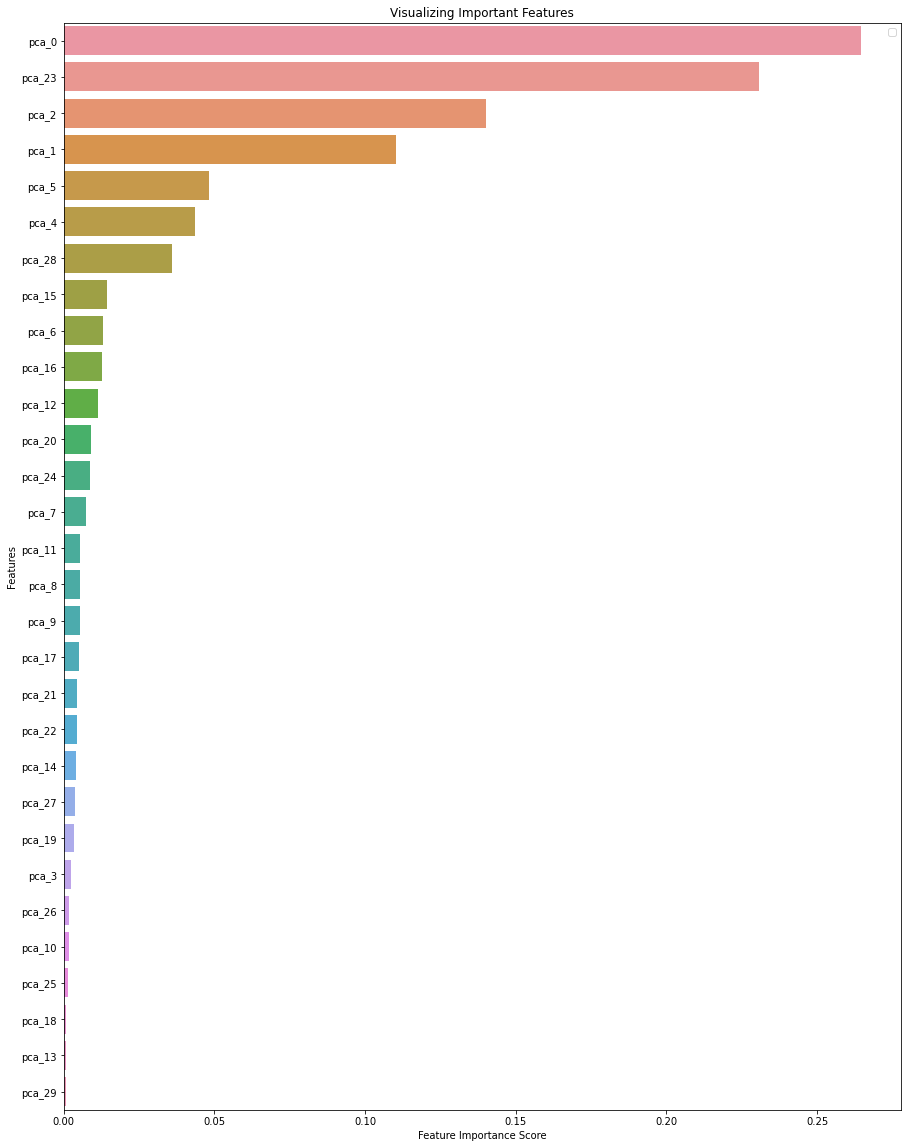

In [66]:
df6 = pd.read_csv('../input/tide-match-data/final_features.csv')
feats = list(df6.columns)
feats.remove('class')
final_preds = 0
x1 = df6[feats]
y1 = df6['class']*1

pca = PCA(n_components=30, random_state = 42)
feature_cols = feats
X_pca = pca.fit_transform(df6[feature_cols])
X_pca = pd.DataFrame(X_pca, columns=['pca_'+ str(i) for i in range(30)], index=df6.index)
df6 = pd.concat([X_pca], axis=1)
df6.head()
x1 = df6
feats = list(df6.columns)

x_train, x_test, y_train,y_test = train_test_split(x1,y1, test_size=0.2,random_state=42, stratify = y1)    
#x_train, y_train = SMOTE(sampling_strategy = .4, random_state=42).fit_resample(x_train, y_train)
skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 42)
#x_train = x1.reset_index(drop = True)
#y_train = y1.reset_index(drop = True)
for train_index, test_index in skf.split(x_train, y_train):
    x_tr, _ = x_train.values[train_index], x_train.values[test_index]
    y_tr, _ = y_train[train_index], y_train[test_index]
    x_tr = pd.DataFrame(x_tr)
    x_tr.columns = feats
    x_test = pd.DataFrame(x_test)
    x_test.columns = feats
    clf1 = XGBClassifier().fit(x_tr, y_tr)
    pred = clf1.predict_proba(x_test)
    final_preds = final_preds + pred/10
    
print(classification_report(y_test, np.argmax(final_preds, axis = 1)))
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
plot_precision_recall_curve(clf1,x_test, y_test,ax=ax1)
skplt.metrics.plot_roc_curve(y_test, final_preds)
sns.heatmap(confusion_matrix(y_test, np.argmax(final_preds, axis = 1)),annot=True, fmt='d',cmap='Reds', ax=ax2,)
ax2.set_xlabel('Pred')
ax2.set_ylabel('True')

feature_imp1 = pd.Series(clf1.feature_importances_,index=x1.columns).sort_values(ascending=False)
plt.figure(figsize=(15,20))
sns.barplot(x=feature_imp1, y=feature_imp1.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()


without PCA feature reduction just to know which features perform well and were given more importance

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2205
           1       0.99      0.74      0.85       202

    accuracy                           0.98      2407
   macro avg       0.98      0.87      0.92      2407
weighted avg       0.98      0.98      0.98      2407



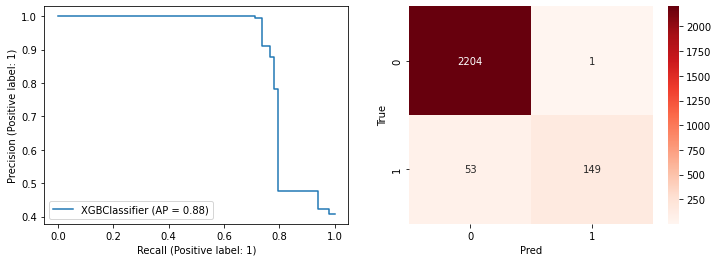

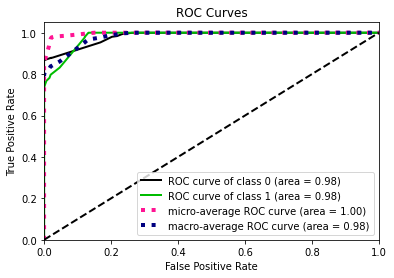

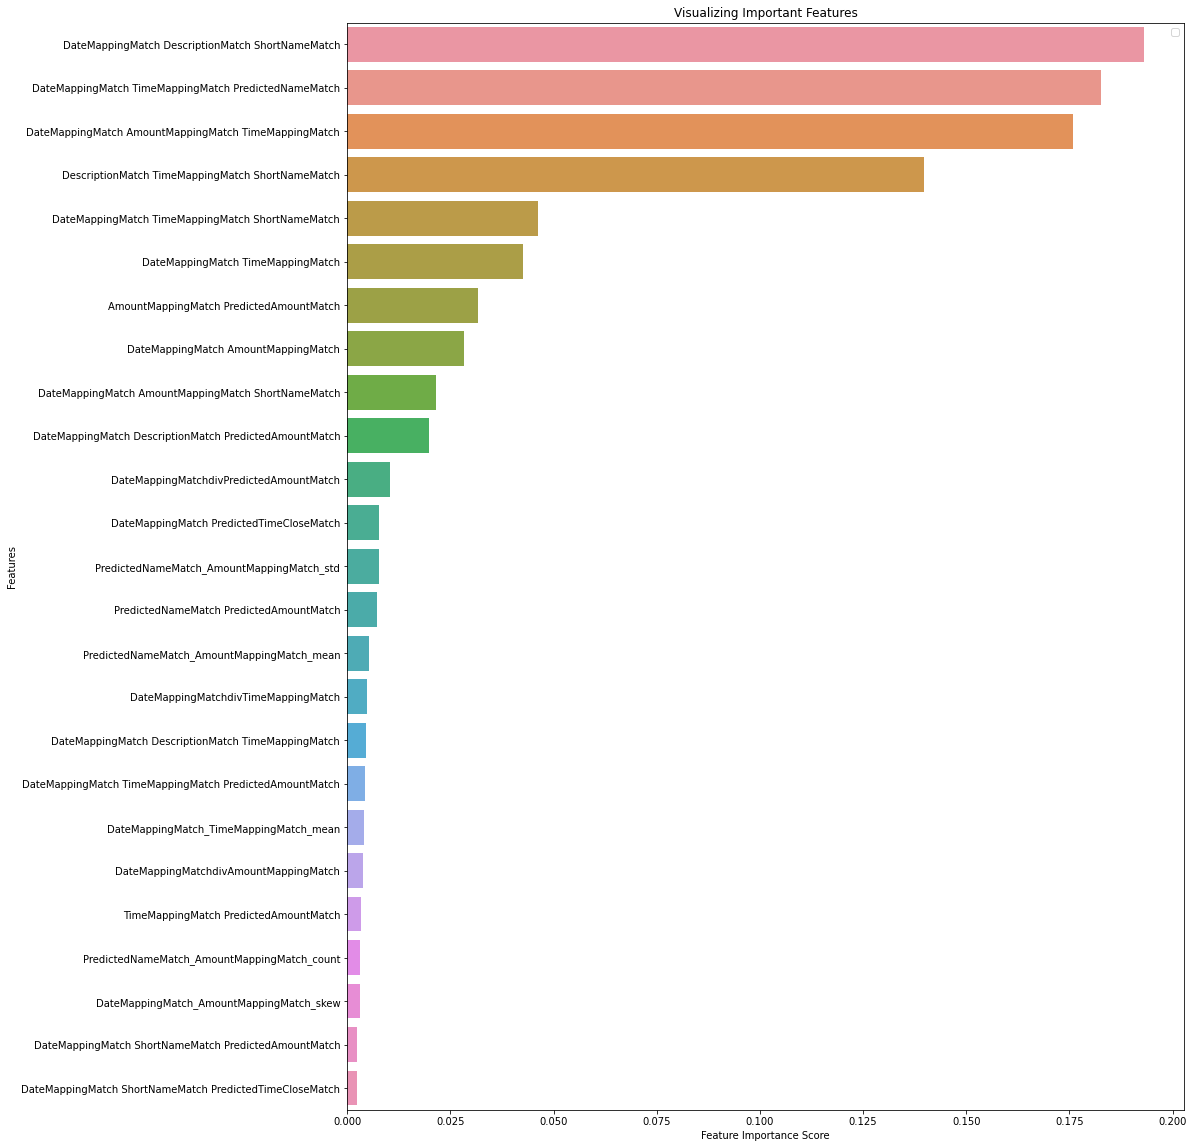

In [67]:
df6 = pd.read_csv('../input/tide-match-data/final_features.csv')
feats = list(df6.columns)
feats.remove('class')
final_preds = 0
x1 = df6[feats]
y1 = df6['class']*1

x_train, x_test, y_train,y_test = train_test_split(x1,y1, test_size=0.2,random_state=42, stratify = y1)    
#x_train, y_train = SMOTE(sampling_strategy = .4, random_state=42).fit_resample(x_train, y_train)
skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 42)
#x_train = x1.reset_index(drop = True)
#y_train = y1.reset_index(drop = True)
for train_index, test_index in skf.split(x_train, y_train):
    x_tr, _ = x_train.values[train_index], x_train.values[test_index]
    y_tr, _ = y_train[train_index], y_train[test_index]
    x_tr = pd.DataFrame(x_tr)
    x_tr.columns = feats
    x_test = pd.DataFrame(x_test)
    x_test.columns = feats
    clf1 = XGBClassifier().fit(x_tr, y_tr)
    pred = clf1.predict_proba(x_test)
    final_preds = final_preds + pred/10
    
print(classification_report(y_test, np.argmax(final_preds, axis = 1)))
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
plot_precision_recall_curve(clf1,x_test, y_test,ax=ax1)
skplt.metrics.plot_roc_curve(y_test, final_preds)
sns.heatmap(confusion_matrix(y_test, np.argmax(final_preds, axis = 1)),annot=True, fmt='d',cmap='Reds', ax=ax2,)
ax2.set_xlabel('Pred')
ax2.set_ylabel('True')

feature_imp1 = pd.Series(clf1.feature_importances_,index=x1.columns).sort_values(ascending=False)[:25]
plt.figure(figsize=(15,20))
sns.barplot(x=feature_imp1, y=feature_imp1.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()


as you can see some feature name are seen over most of them are interaction based feature some of them are features that are a product of aggregations also but both of these feature categories either of interaction of groupby aggregation perform decently

these parts are nothing but a function form of doing
1. data_creation
2. feature_creation
3. train_model
4. prediction_pipeline

Data creation - 
this function covers the part of changing unformated csv data into the form where it could be used to create labels and feature on from the provided format of the data. it takes 3 parameters 

1. is path of the csv file (this should be in the same format as provided)
2. is mode which is train/test
3. is output_dir where it will save the initial dataset

feature_creation - 
this function the section where the sanitized and formated dataset from the previous step is converted into a pack of features here every feature related to interactions , groupby and aggregations are made it also take 3 parameters with same defination as of above point
it outputs the dataset with features and saves it in the provided output directory

train_model -
this function is an combination of (data creation ,feature_creation , training) as you can directly provide the unformated csv file and it will output the **models and a pca** object into the specified directory.
this function produces **10 models for 10 folds** we can use all of them when predicting or we can choose one as every fold performs relatively same 

prediction_pipeline-
this function will require the path of unformated csv, convert that into sanitized csv and then into features table. this then passes that features though PCA loaded from outputs of training, and then these features are used for ***predicting the probablity that whether a data point or a row in the dataframe belongs to class 1 or not or to simply say whether its a match or not***
takes 4 arguments 
1. path of unorganized csv
2. path of pca object(obtained from training)
3. path of model object(obtained from training)
4. is the path of output dir

In [68]:
def data_creation(path, mode, output_dir = './'):
    df = pd.read_csv(path)
    l = []
    for i in df.values:
        l.append(i[-1].split(":"))
    df = df.reset_index()
    df2 = pd.DataFrame(l)
    df1 = df[['level_0','level_1','level_2']]
    df1.columns = df.columns[-1].split(":")[:3]
    df2.columns = df.columns[-1].split(":")[3:]
    df3 = pd.concat([df1,df2], axis = 1)
    df3['company_id'] = df3['company_id'].apply(lambda x : x.split(":")[0])
    df3['matched_transaction_id'] = df3['matched_transaction_id'].apply(lambda x : x.split(":")[0])
    
    if mode == 'train':
        df4 = df3[df3['matched_transaction_id']==df3['feature_transaction_id']]
        df4['class'] = 1
        df5 = df3[df3['matched_transaction_id']!=df3['feature_transaction_id']]
        df5['class'] = 0
        for i in df3.columns:
            df3[i] = df3[i].astype(float)
            df4[i] = df4[i].astype(float)
            df5[i] = df5[i].astype(float)
        df6 = pd.concat([df4,df5]).reset_index(drop = True)
        df6.to_csv(output_dir+'/train_data.csv', index = False)
        return output_dir+'/train_data.csv'
        
    if mode == 'test':
        for i in df3.columns:
            df3[i] = df3[i].astype(float)
        df3.to_csv(output_dir+'/test_data.csv', index = False)
        return output_dir+'/test_data.csv'

In [69]:
def feature_creation(path, mode, output_dir = './'):
    
    df6 = pd.read_csv(path)
    feats = list(df6.columns)
    if mode == 'train':
        feats.remove('class')
    else:
        pass
    
    df6[feats] = df6[feats] + 1
    df6 = df6.drop(columns = ['receipt_id','company_id','matched_transaction_id','feature_transaction_id','DifferentPredictedDate', 'DifferentPredictedTime'])
    feats = ['DateMappingMatch','AmountMappingMatch','DescriptionMatch','TimeMappingMatch','PredictedNameMatch',
     'ShortNameMatch','PredictedAmountMatch','PredictedTimeCloseMatch']
    numerical_cols_original = ['DateMappingMatch','PredictedNameMatch','DescriptionMatch']
    categorical_cols_original = ['AmountMappingMatch','TimeMappingMatch','PredictedAmountMatch','ShortNameMatch','PredictedTimeCloseMatch']
    
    poly_feats = PolynomialFeatures(degree = 3, interaction_only = True)
    total_data = pd.DataFrame(poly_feats.fit_transform(df6[feats]))
    total_data.columns = poly_feats.get_feature_names_out(feats)
    
    df7 = total_data.drop(columns = ['1'])
    
    feats = ['DateMappingMatch', 'AmountMappingMatch', 'DescriptionMatch','TimeMappingMatch', 'PredictedNameMatch', 'ShortNameMatch','PredictedAmountMatch', 'PredictedTimeCloseMatch']
    for i in feats:
        feats2work = feats
        feats2work.remove(i)
        for j in feats2work:
            finals = df6.groupby(i)[j].agg(['mean', 'std', 'min', 'skew', 'count', 'nunique','median','cumsum'])
            finals.columns = [i + '_' + j + '_' + k for k in finals.columns]
            df6 = df6.join(finals, on = i)
            
    columns_a = ['DateMappingMatch', 'DescriptionMatch', 'TimeMappingMatch', 'ShortNameMatch', 'PredictedAmountMatch']
    columns_b = ['AmountMappingMatch', 'PredictedTimeCloseMatch', 'PredictedNameMatch']

    for col_a in columns_a:
        for col_b in columns_b:
            for df in [df6]:
                df[f'{col_a}_div_mean_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].mean()
                df[f'{col_a}_div_std_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].std()
                df[f'{col_a}_div_median_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].median()
                df[f'{col_a}_div_var_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].count()
                df[f'{col_a}_div_max_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].max()
                df[f'{col_a}_div_min_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].min()
            
    for col_a in columns_a:
        for col_b in columns_b:
            for df in [df6]:
                df[f'{col_a}_sub_mean_{col_b}'] = df[col_a]   - df.groupby([col_b])[col_a].mean()
                df[f'{col_a}_sub_std_{col_b}'] = df[col_a]    - df.groupby([col_b])[col_a].std()
                df[f'{col_a}_sub_median_{col_b}'] = df[col_a] - df.groupby([col_b])[col_a].median()
                df[f'{col_a}_sub_var_{col_b}'] = df[col_a]    - df.groupby([col_b])[col_a].var()
                df[f'{col_a}_sub_max_{col_b}'] = df[col_a]    - df.groupby([col_b])[col_a].max()
                df[f'{col_a}_sub_min_{col_b}'] = df[col_a]    - df.groupby([col_b])[col_a].min()
                
    feats = ['DateMappingMatch', 'AmountMappingMatch', 'DescriptionMatch','TimeMappingMatch', 'PredictedNameMatch', 'ShortNameMatch','PredictedAmountMatch', 'PredictedTimeCloseMatch']
    for i in feats:
        feats2work = feats
        feats2work.remove(i)
        for j in feats2work:
            df6[i+'div'+j] = df6[i]/df6[j]
            df6[i+'mul'+j] = df6[i]*df6[j]
            df6[i+'add_div'+j] = (df6[i]+df6[j])/df6[i]
            df6[i+'sub_mul'+j] = (df6[i]-df6[j])*df6[i]
            
    df7 = df7.drop(columns = ['DateMappingMatch', 'AmountMappingMatch', 
                          'DescriptionMatch','TimeMappingMatch', 'PredictedNameMatch', 
                          'ShortNameMatch','PredictedAmountMatch', 'PredictedTimeCloseMatch'])
    df6 = pd.concat([df7, df6], axis = 1)
    df6 = df6.fillna(0)
    df6.replace([np.inf, -np.inf], 0, inplace=True)
    df6.to_csv(output_dir+'/final_features'+mode+'.csv',index = False)
    return output_dir+'/final_features'+mode+'.csv'

In [70]:
def train_model(path = '../input/tide-match-data/data_interview_test.csv', output_dir = './'):
    
    train_data_path = data_creation(path, mode = 'train')
    train_data_path = feature_creation(train_data_path , mode = 'train')
    
    df6 = pd.read_csv(train_data_path)
    feats = list(df6.columns)
    feats.remove('class')
    final_preds = 0
    x1 = df6[feats]
    y1 = df6['class']*1
    pca = PCA(n_components=50, random_state = 42)
    feature_cols = feats
    X_pca = pca.fit_transform(df6[feature_cols])

    X_pca = pd.DataFrame(X_pca, columns=['pca_'+ str(i) for i in range(50)], index=df6.index)

    df6 = pd.concat([X_pca], axis=1)

    x1 = df6
    feats = list(df6.columns)
    x_train, x_test, y_train,y_test = train_test_split(x1,y1, test_size=0.2,random_state=42, stratify = y1)    

    x_train, y_train = SMOTE(sampling_strategy = .4, random_state=42).fit_resample(x_train, y_train)
    skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 42)
    x_train = x1.reset_index(drop = True)
    y_train = y1.reset_index(drop = True)
    fold = 0
    for train_index, test_index in skf.split(x_train, y_train):
        x_tr, x_tt = x_train.values[train_index], x_train.values[test_index]
        y_tr, y_tt = y_train[train_index], y_train[test_index]
        x_tr = pd.DataFrame(x_tr)
        x_tr.columns = feats
        x_test = pd.DataFrame(x_test)
        x_test.columns = feats
        clf = XGBClassifier(random_state = 42).fit(x_tr, y_tr)
        pred = clf.predict_proba(x_test)
        final_preds = final_preds + pred/10
        joblib.dump(clf, 'xgb_classifier'+str(fold)+'.pkl')
        fold = fold + 1
    
    print(classification_report(y_test, np.argmax(final_preds, axis = 1)))
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
    plot_precision_recall_curve(clf,x_test, y_test,ax=ax1)
    skplt.metrics.plot_roc_curve(y_test, final_preds)
    sns.heatmap(confusion_matrix(y_test, np.argmax(final_preds, axis = 1)),annot=True, fmt='d',cmap='Reds', ax=ax2,)
    ax1.set_xlabel('Pred')
    ax1.set_ylabel('True')
    plt.show()

    pkl.dump(pca, open(output_dir+"/pca.pkl","wb"))

In [71]:
def prediction_pipeline(path = '../input/tide-match-data/data_interview_test.csv', pca_path = 'pca.pkl', model_path = 'xgb_classifier1.pkl', output_dir = './'):
    
    test_data_path = data_creation(path, mode = 'test')
    test_data_path = feature_creation(test_data_path , mode = 'test')
    df6 = pd.read_csv(test_data_path)
    feats = list(df6.columns)
    pca = pkl.load(open(pca_path,'rb'))
    X_pca = pca.transform(df6[feats])

    X_pca = pd.DataFrame(X_pca, columns=['pca_'+ str(i) for i in range(50)], index=df6.index)
    model = joblib.load(model_path)
    preds_proba = model.predict_proba(X_pca)[:,1]
    #print(sum(preds_proba>.3), sum(preds_proba>.2), sum(preds_proba>.5))
    return preds_proba